In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview


This tutorial demonstrates how to use Vertex AI for E2E MLOps on Google Cloud in production. This tutorial covers formalization: get started with BigQuery ML pipeline components.

### Objective

In this tutorial, you learn how to use prebuilt `Google Cloud Pipeline Components` for `BigQuery ML`.

This tutorial uses the following Google Cloud ML services:

- `BigQuery ML`
- `Google Cloud Pipeline Components`
- `Vertex AI, Model and Endpoint` resources


The steps performed include:

- Construct a pipeline for:
    - Training BigQuery ML model.
    - Evaluating the BigQuery ML model.
    - Exporting the BigQuery ML model.
    - Importing the BigQuery ML model to a Vertex AI model.
    - Deploy the Vertex AI model.


### Dataset

The dataset used for this tutorial is the available in github https://github.com/themlguy-tf/explainable-ai-garage.git

### Costs
This tutorial uses billable components of Google Cloud:

- Vertex AI
- Cloud Storage
- BigQuery

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage pricing](https://cloud.google.com/storage/pricing) and [BigQuery pricing](https://cloud.google.com/bigquery/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Installations

Install the packages required for executing the notebook.

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,dataflow.googleapis.com).

1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [2]:
#PROJECT_ID = "prj-ai-ml-auto"  # @param {type:"string"}
PROJECT_ID = "[your-project-id]" #<ENTER YOUR PROJECT ID

In [ ]:
#Enter a user id - could be your name too or Qwiklab_user name without the @domain.com   ; see example below

USER_NAME = "<enter a user id>" 

#e.g.
USER_NAME = "google"


In [3]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

print("Project ID:", PROJECT_ID)

Project ID: ai-ml-meta-auto
Project ID: ai-ml-meta-auto


! gcloud config set project $PROJECT_ID

#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [3]:
REGION = "us-central1"  # @param {type:"string"}
if REGION == "[your-region]":
    REGION = "us-central1"

print("REGION: ", REGION)

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append the timestamp onto the name of resources you create in this tutorial.

In [4]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you initialize the Vertex SDK for Python, you specify a Cloud Storage staging bucket. The staging bucket is where all the data associated with your dataset and model resources are retained across sessions.

Set the name of your Cloud Storage bucket below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [ ]:
BUCKET_NAME = ""+USER_NAME+"_"+TIMESTAMP # @param {type:"string"} 
BUCKET_URI = f"gs://{BUCKET_NAME}"


print("BUCKET_NAME: ",BUCKET_NAME)
print("BUCKET_URI: ",BUCKET_URI)

In [6]:
if BUCKET_URI == "" or BUCKET_URI is None or BUCKET_URI == "gs://[your-bucket-name]":
    BUCKET_URI = "gs://" + PROJECT_ID + "aip-" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_URI

In [ ]:
!gsutil cp ./feat_mortgage_data.csv $BUCKET_URI

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [7]:
! gsutil ls -al $BUCKET_URI

         0  2022-09-07T01:15:57Z  gs://ai-ml-meta-auto-vertexai/bqml/#1662513357028893  metageneration=1
 135458194  2022-09-07T02:28:22Z  gs://ai-ml-meta-auto-vertexai/bqml/feat_mortgage_data.csv#1662517702860012  metageneration=1
    120575  2022-09-07T17:59:16Z  gs://ai-ml-meta-auto-vertexai/bqml/import_file.csv#1662573556324394  metageneration=1
                                 gs://ai-ml-meta-auto-vertexai/bqml/bq_query/
                                 gs://ai-ml-meta-auto-vertexai/bqml/bqmodel/
TOTAL: 3 objects, 135578769 bytes (129.3 MiB)


#### Service Account

**If you don't know your service account**, try to get your service account using `gcloud` command by executing the second cell below.

*Note:* The code for automatically finding your service account works on a user-managed Workbench AI noteboook. If you are using a fully-managed notebook, you will need to manually enter your service account.

In [8]:
#Enter the service account copied earlier; see example below
SERVICE_ACCOUNT = '<Enter >'  # @param {type:"string"}

#e.g.
SERVICE_ACCOUNT = '670723894630-compute@developer.gserviceaccount.com'  # @param {type:"string"}


In [5]:
SERVICE_ACCOUNT = "[your-service-account]"

#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step -- you only need to run these once per service account.

In [10]:
print("Grant Permissions to the service account")
      
! gsutil iam -r ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam -r ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

! gsutil iam -r ch serviceAccount:{SERVICE_ACCOUNT}:roles/bigquery.dataOwner

Omitting prefix "gs://ai-ml-meta-auto-vertexai/bqml/". (Did you mean to do iam -r?)
CommandException: No URLs matched. Do the files you're operating on exist?
Omitting prefix "gs://ai-ml-meta-auto-vertexai/bqml/". (Did you mean to do iam -r?)
CommandException: No URLs matched. Do the files you're operating on exist?


## BigQuery Data Load
Load the feat_mortgage_data in the BigQuery.
To verify this, please open BigQuery from the Google Console - the main Google Console

In [50]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client()


dataset_id = "{}.bqml".format(client.project)
# Construct a full Dataset object to send to the API.
dataset = bigquery.Dataset(dataset_id)

# TODO(developer): Specify the geographic location where the dataset should reside.
dataset.location = REGION

# Send the dataset to the API for creation, with an explicit timeout.
# Raises google.api_core.exceptions.Conflict if the Dataset already
# exists within the project.
dataset = client.create_dataset(dataset, timeout=30)  # Make an API request.
print("Created dataset {}.{}".format(client.project, dataset.dataset_id)

# TODO(developer): Set table_id to the ID of the table to create.
table_id =  PROJECT_ID + ".bqml.feat_mortgage_data"

job_config = bigquery.LoadJobConfig(
    autodetect=True,
    skip_leading_rows=1,
    # The source format defaults to CSV, so the line below is optional.
    source_format=bigquery.SourceFormat.CSV,
)
uri = BUCKET_URI+"/feat_mortgage_data.csv"

load_job = client.load_table_from_uri(
    uri, table_id, job_config=job_config
)  # Make an API request.

load_job.result()  # Waits for the job to complete.

destination_table = client.get_table(table_id)  # Make an API request.
print("Loaded {} rows in BigQuery.".format(destination_table.num_rows))

Loaded 1000 rows.


## Check the table in BigQuery
Head over to the Google Cloud Platform Console, and look for BigQuery in the Navigation Menu or use the search bar on the Blue Ribbon.
Confirm that you are able to see the following table in BigQuery. 

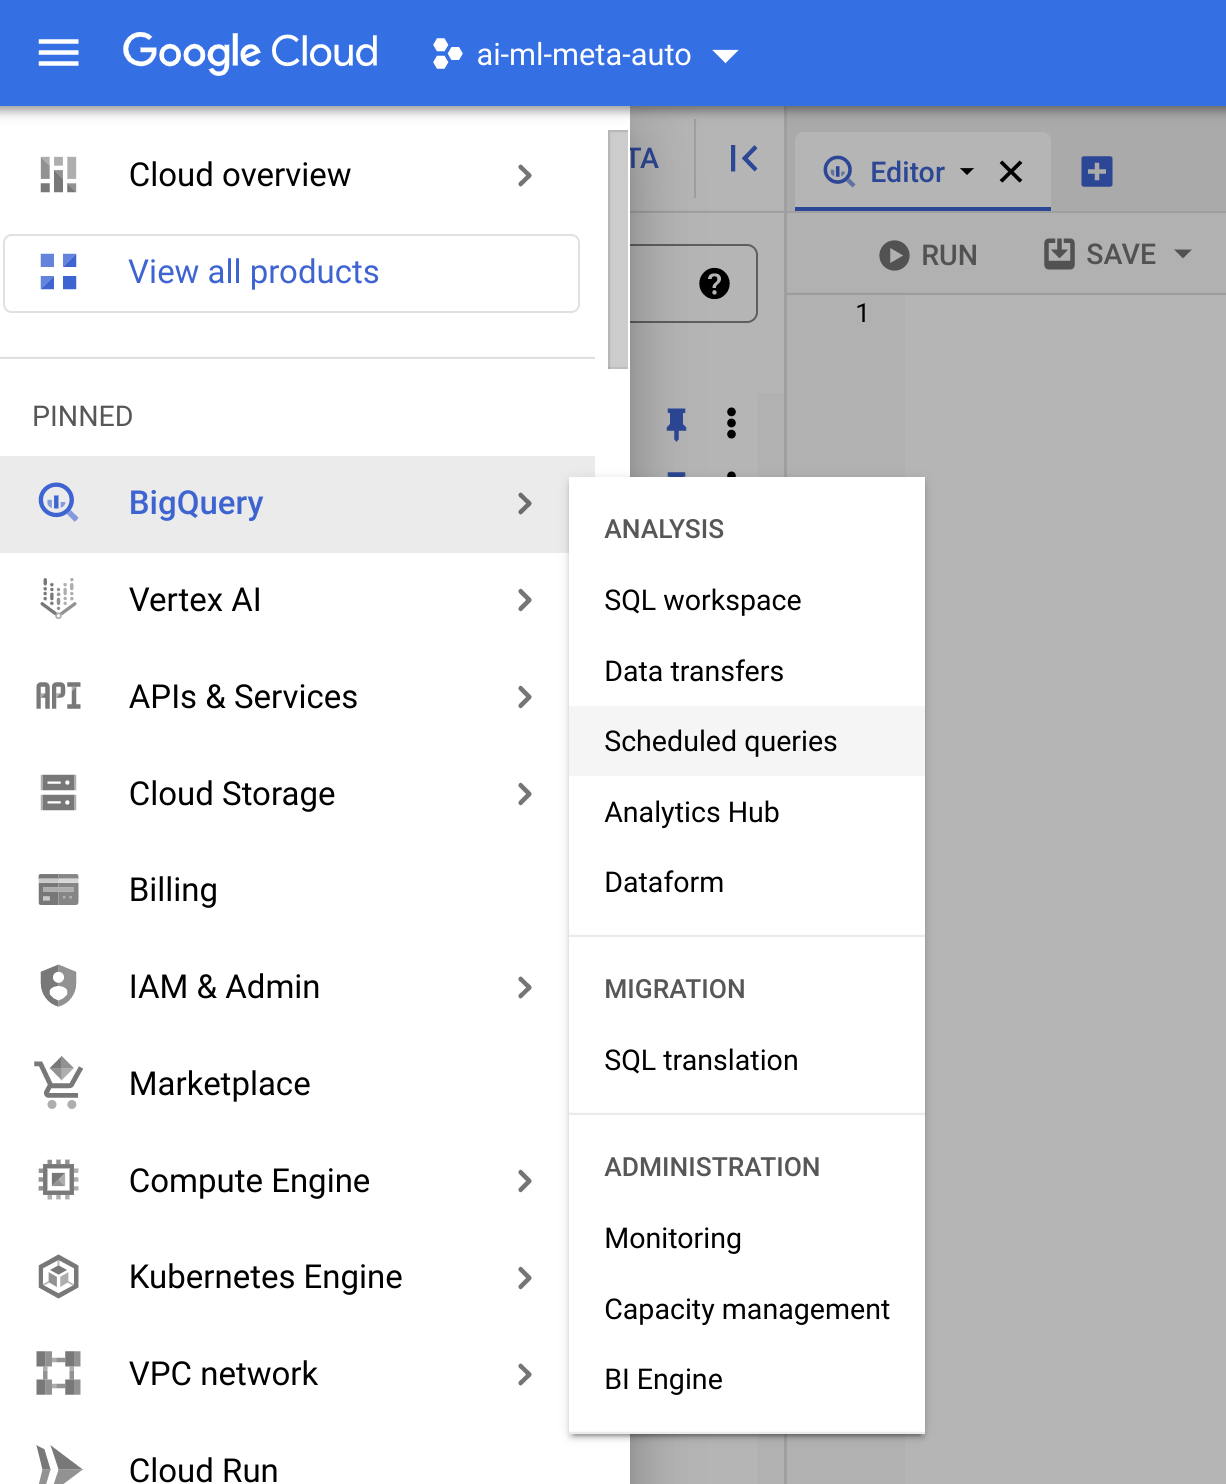

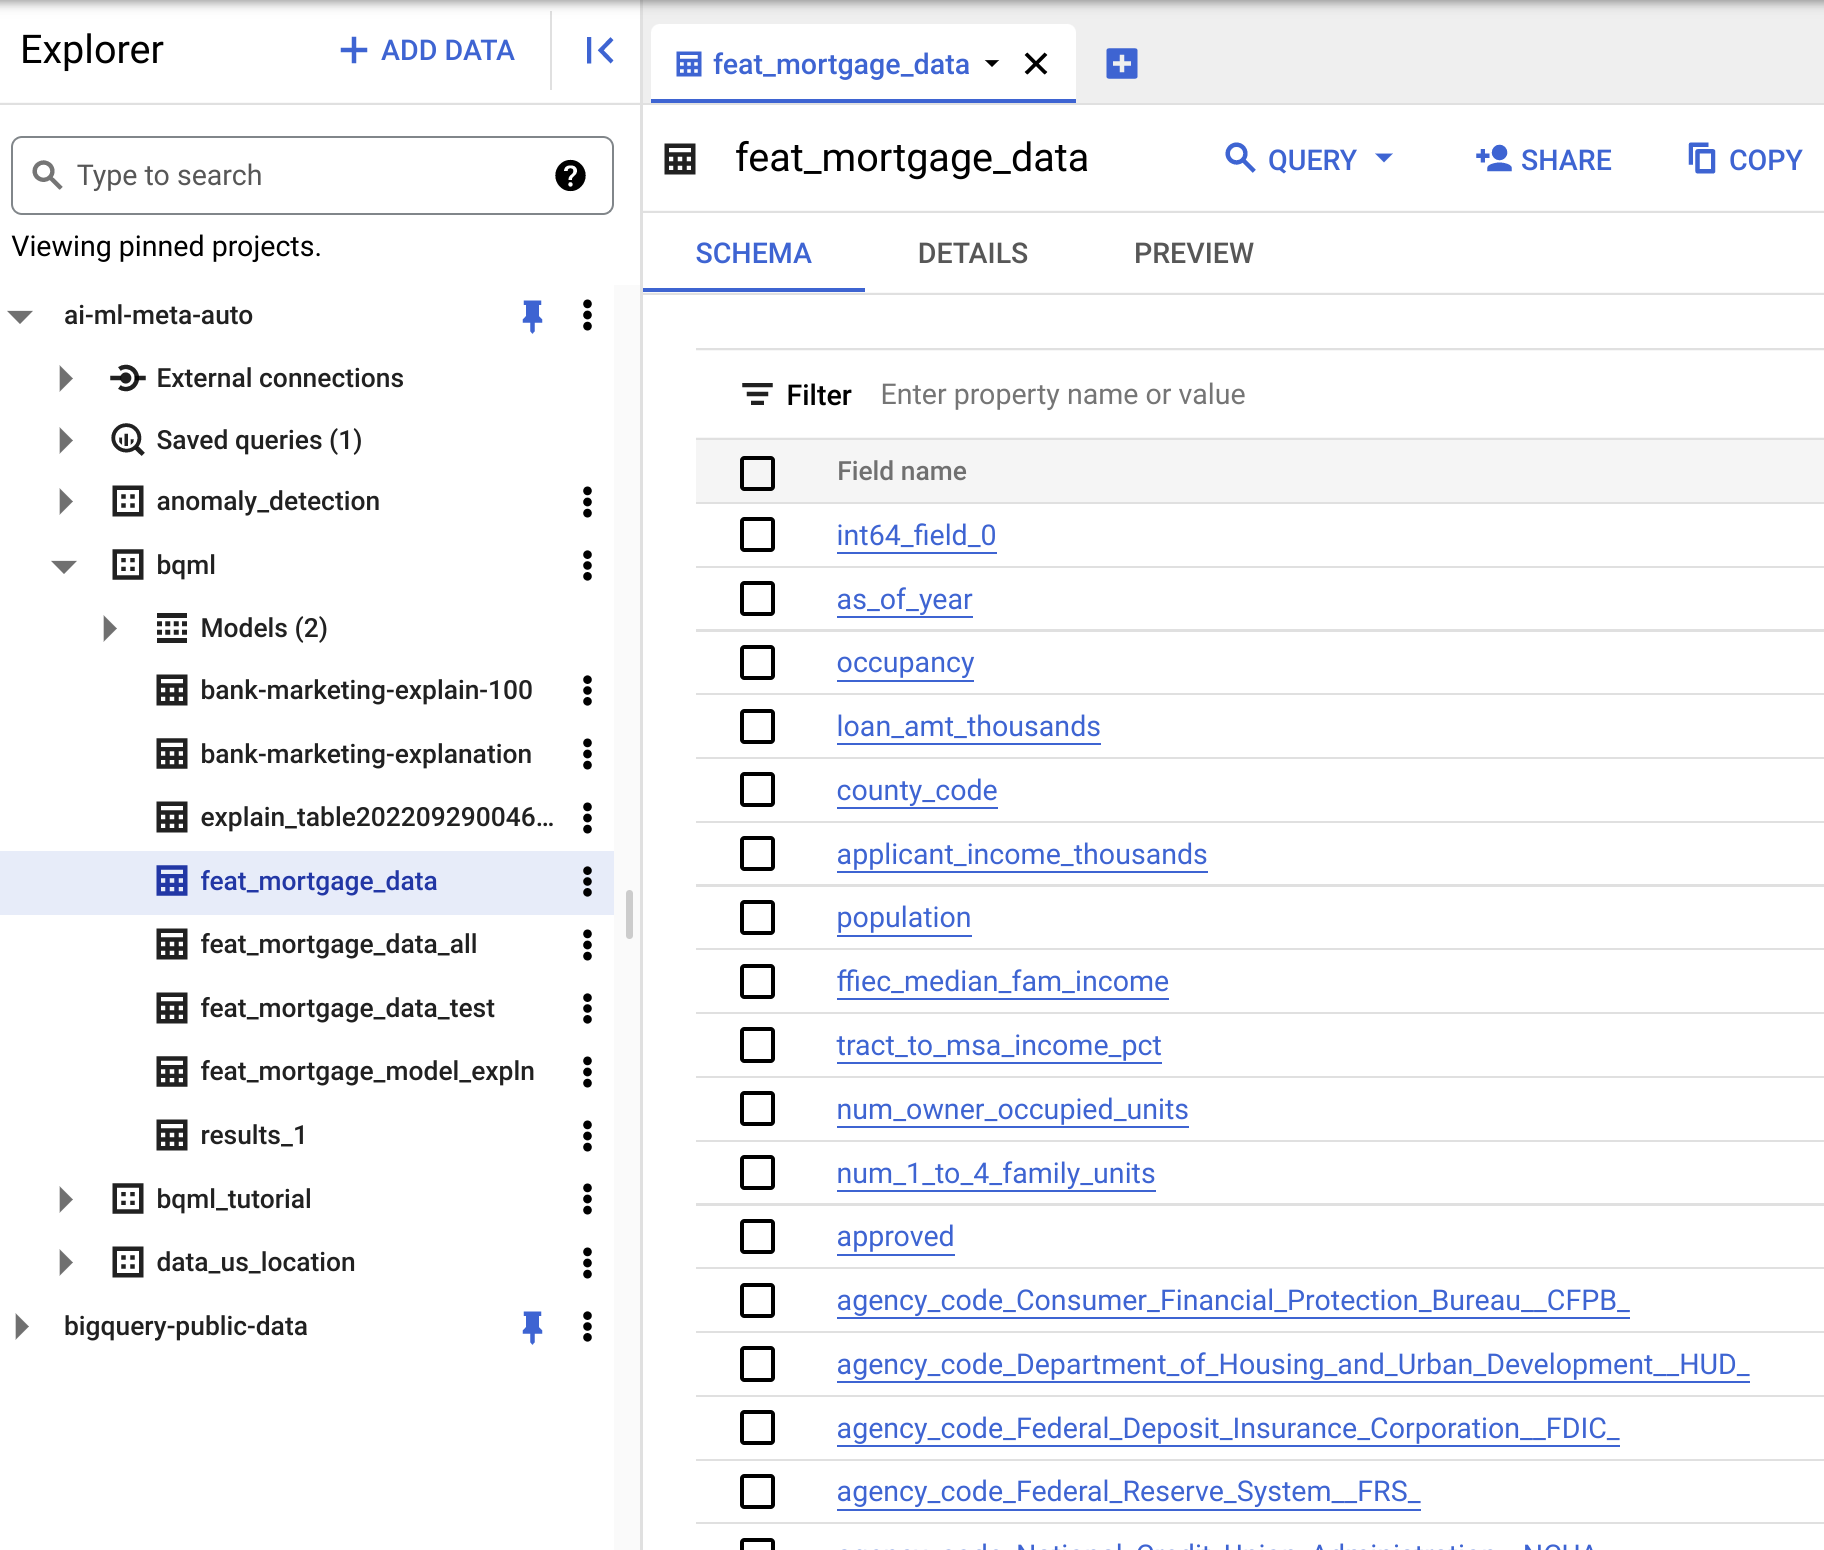


### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [ ]:
#Ignore any warnings that might appear

!pip install --quiet kfp==1.8.13

In [ ]:
#Ignore any warnings that might appear

! pip3 install --upgrade google-cloud-pipeline-components $USER_FLAG -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.40.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.5.1 which is incompatible.
apache-beam 2.40.0 requires pyarrow<8.0.0,>=0.15.1, but you have pyarrow 9.0.0 which is incompatible.


In [12]:
import google.cloud.aiplatform as aip

In [13]:
import json
import os
from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import HTML, Artifact, Condition, Input, Output, component


#### Import BigQuery

Import the BigQuery package into your Python environment.

In [14]:
from google.cloud import bigquery

#### Import TensorFlow

Import the TensorFlow package into your Python environment.

In [15]:
import tensorflow as tf

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [16]:
aip.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

### Create BigQuery client

Create the BigQuery client.

In [17]:
bqclient = bigquery.Client()

#### Set hardware accelerators

You can set hardware accelerators for prediction.

Set the variable `DEPLOY_GPU/DEPLOY_NGPU` to use a container image supporting a GPU and the number of GPUs allocated to the virtual machine (VM) instance. For example, to use a GPU container image with 4 Nvidia Telsa K80 GPUs allocated to each VM, you would specify:

    (aip.AcceleratorType.NVIDIA_TESLA_K80, 4)

Otherwise specify `(None, None)` to use a container image to run on a CPU.

Learn more [here](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators) hardware accelerator support for your region

In [18]:
if os.getenv("IS_TESTING_DEPLOY_GPU"):
    DEPLOY_GPU, DEPLOY_NGPU = (
        aip.gapic.AcceleratorType.NVIDIA_TESLA_K80,
        int(os.getenv("IS_TESTING_DEPLOY_GPU")),
    )
else:
    DEPLOY_GPU, DEPLOY_NGPU = (aip.gapic.AcceleratorType.NVIDIA_TESLA_K80, 1)

#### Set pre-built containers

Set the pre-built Docker container image for prediction.

- Set the variable `TF` to the TensorFlow version of the container image. For example, `2-1` would be version 2.1, and `1-15` would be version 1.15. The following list shows some of the pre-built images available:


For the latest list, see [Pre-built containers for prediction](https://cloud.google.com/ai-platform-unified/docs/predictions/pre-built-containers).

In [33]:
if os.getenv("IS_TESTING_TF"):
    TF = os.getenv("IS_TESTING_TF")
else:
    TF = "2.5".replace(".", "-")

if TF[0] == "2":
    if DEPLOY_GPU:
        DEPLOY_VERSION = "tf2-gpu.{}".format(TF)
    else:
        DEPLOY_VERSION = "tf2-cpu.{}".format(TF)
else:
    if DEPLOY_GPU:
        DEPLOY_VERSION = "tf-gpu.{}".format(TF)
    else:
        DEPLOY_VERSION = "tf-cpu.{}".format(TF)

DEPLOY_IMAGE = "{}-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(
    REGION.split("-")[0], DEPLOY_VERSION
)

print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU)

Deployment: us-docker.pkg.dev/vertex-ai/prediction/tf2-gpu.2-5:latest AcceleratorType.NVIDIA_TESLA_K80


#### Location of BigQuery training data.

Now set the variable `IMPORT_FILE`, `BQ_TABLE`, and the `EXPLAIN_TABLE` to the location of the data table in BigQuery.

In [38]:
IMPORT_FILE = PROJECT_ID + ".bqml.feat_mortgage_data"
BQ_TABLE = PROJECT_ID + ".bqml.feat_mortgage_data"
explain_table = "explain_table_"+TIMESTAMP

In [90]:
## Set up pipeline variable

In [20]:
DATA_PATH = "data"
KFP_COMPONENTS_PATH = "components"
PIPELINES_PATH = "pipelines"

! mkdir -m 777 -p {KFP_COMPONENTS_PATH}
! mkdir -m 777 -p {PIPELINES_PATH}
! mkdir -m 777 -p {KFP_COMPONENTS_PATH}/custom_components

In [21]:

! mkdir -m 777 -p {KFP_COMPONENTS_PATH}/custom_components

## Create Custom Functions for Evaluation Metrics

In [29]:
from typing import NamedTuple


@component(
    base_image="python:3.8-slim",
    packages_to_install=["jinja2", "pandas", "matplotlib"],
    output_component_file=f"{KFP_COMPONENTS_PATH}/custom_components/build_bq_evaluate_metrics.yaml",
)
def get_model_evaluation_metrics(
    metrics_in: Input[Artifact]
) -> NamedTuple("Outputs", [("accuracy", float)]):
    """
    Get the accuracy from the metrics
    Args:
        metrics_in: metrics artifact
    Returns:
        accuracy: accuracy
    """

    import pandas as pd


    def get_column_names(header):
        """
        Helper function to get the column names from the metrics table.
        Args:
            header: header
        Returns:
            column_names: column names
        """
        header_clean = header.replace("_", " ")
        header_abbrev = "".join([h[0].upper() for h in header_clean.split()])
        header_prettied = f"{header_clean} ({header_abbrev})"
        return header_prettied

    # Extract rows and schema from metrics artifact
    rows = metrics_in.metadata["rows"]
    schema = metrics_in.metadata["schema"]

    # Convert into a tabular format
    columns = [metrics["name"] for metrics in schema["fields"] if "name" in metrics]
    records = []
    for row in rows:
        records.append([dl["v"] for dl in row["f"]])
    metrics = (
        pd.DataFrame.from_records(records, columns=columns)
        .astype(float)
        .round(3)
    )
    metrics = metrics.reset_index()

    # Create the HTML artifact for the metrics
    pretty_columns = list(
        map(
            lambda h: get_column_names(h)
            if h != columns[0]
            else h.replace("_", " ").capitalize(),
            columns,
        )
    )

    # Create metrics dictionary for the model
    accuracy = round(float(metrics.accuracy), 3)
    component_outputs = NamedTuple("Outputs", [("accuracy", float)])

    return component_outputs(accuracy)


### Construct pipeline for BigQuery ML training, exporting and deployment

Next, construct the pipeline with the following tasks:

- Create a BigQuery schema for the dataset.
- Train a BigQuery ML model.
- Evaluate the BigQuery ML model.
- Make a batch prediction with the BigQuery ML model. *Note:* The same data (table) is used for both training and prediction.
- Export the BigQuery ML model.
- Import the exported model artifacts to a Vertex AI Model resource.
- Deploy the Vertex AI Model resource to a Vertex AI Endpoint resource.

In [42]:
PIPELINE_ROOT = f"{BUCKET_URI}/bq_query"
PERF_THRESHOLD = .97

@dsl.pipeline(name="mortgage-data-pipeline-new", pipeline_root=PIPELINE_ROOT)
def pipeline(
    bq_table: str,
    label: str,
    dataset: str,
    model: str,
    artifact_uri: str,
    num_trials: int,
    deploy_image: str,
    machine_type: str,
    min_replica_count: int,
    max_replica_count: int,
    display_name: str,
    accelerator_type: str,
    accelerator_count: int,
    project: str = PROJECT_ID,
    location: str = "US",
    region: str = "us-central1",
):
    #from google_cloud_pipeline_components.types import artifact_types
    
    from google_cloud_pipeline_components.v1.bigquery import (
        BigqueryCreateModelJobOp, BigqueryEvaluateModelJobOp,
        BigqueryExportModelJobOp, BigqueryPredictModelJobOp,
        BigqueryQueryJobOp, BigqueryExplainPredictModelJobOp)
    from google_cloud_pipeline_components.v1.endpoint import (EndpointCreateOp,
                                                              ModelDeployOp)
    from google_cloud_pipeline_components.v1.model import ModelUploadOp
    from kfp.v2.components import importer_node

    # bq_dataset = BigqueryQueryJobOp(
    #     project=project, location="US", query=f"CREATE SCHEMA {dataset}"
    # )

    bq_train_model_op = BigqueryCreateModelJobOp(
        project=project,
        location="us-central1",
        query= f"""
            CREATE OR REPLACE MODEL `{dataset}.{model}`    
            OPTIONS(
              MODEL_TYPE=\'LOGISTIC_REG\',
              input_label_cols=[\'approved\'],
              model_registry=\'vertex_ai\',
              vertex_ai_model_version_aliases=[\'logistic_reg\', \'experimental\']
            ) AS

            SELECT
              * EXCEPT(int64_field_0)
            FROM
               `{bq_table}`
            """
    ) 
    _ = BigqueryExplainPredictModelJobOp (
        project = PROJECT_ID, location="us-central1", model=bq_train_model_op.outputs["model"],
        query_statement = f"""
        SELECT * 
        FROM
          ML.EXPLAIN_PREDICT(MODEL `{dataset}.{model}`, 
            (SELECT
              * EXCEPT(int64_field_0)
            FROM  `{bq_table}`
          )
          )
            
        """,
        job_configuration_query={
            "destinationTable": {
                "projectId": PROJECT_ID,
                "datasetId": "bqml",
                "tableId": explain_table,
            }
        },
    )

    bq_evaluate_model_op = BigqueryEvaluateModelJobOp(
        project=PROJECT_ID, location="us-central1", model=bq_train_model_op.outputs["model"]
    ).after(bq_train_model_op)
       # Evaluate model

    # Plot model metrics
    get_evaluation_model_metrics_op = (
        get_model_evaluation_metrics(
            bq_evaluate_model_op.outputs["evaluation_metrics"]
        )
        .after(bq_evaluate_model_op)
        .set_display_name("plot evaluation metrics")
    )

    # Check the model performance.
    with Condition(
        get_evaluation_model_metrics_op.outputs["accuracy"]
        < PERF_THRESHOLD,
        name="accuracy is above threshold",
    ):


        bq_export = BigqueryExportModelJobOp(
            project=project,
            location=location,
            model=bq_train_model_op.outputs["model"],
            model_destination_path=artifact_uri,
        ).after(get_evaluation_model_metrics_op)

        import_unmanaged_model_task = importer_node.importer(
            artifact_uri=artifact_uri,
            artifact_class="",
            metadata={
                "containerSpec": {
                    "imageUri": DEPLOY_IMAGE,
                },
            },
        ).after(bq_export)

        model_upload = ModelUploadOp(
            project=project,
            display_name=display_name,
            unmanaged_container_model=import_unmanaged_model_task.outputs["artifact"],
        ).after(import_unmanaged_model_task)

        endpoint = EndpointCreateOp(
            project=project,
            location=region,
            display_name=display_name,
        ).after(model_upload)

        _ = ModelDeployOp(
            model=model_upload.outputs["model"],
            endpoint=endpoint.outputs["endpoint"],
            dedicated_resources_min_replica_count=min_replica_count,
            dedicated_resources_max_replica_count=max_replica_count,
            dedicated_resources_machine_type=machine_type,
            #accelerator_type=accelerator_type,
            dedicated_resources_accelerator_type=accelerator_type,
            dedicated_resources_accelerator_count=accelerator_count,
            traffic_split={"0": 100},
        )

### Compile and execute the BigQuery ML train, export and deploy pipeline

Next, you compile the pipeline and then execute it. The pipeline takes the following parameters, which are passed as the dictionary `parameter_values`:

- `bq_table`: The BigQuery dataset to train on.
- `label`: The corresponding label for the BigQuery dataset.
- `dataset`: The BigQuery dataset component name.
- `model`: The BigQuery model component name.
- `artifact_uri`: The Cloud Storage location to export the BigQuery model artifacts.
- `num_trials`: If greater than one, will perform hyperparameter tuning for the specified number of trials using the Vertex AI Vizier service.
- `deploy_image`: The container image for serving predictions.
- `machine_type`: The VM for serving predictions.
- `min_replica_count`/`max_replica_count`: The number of virtual machines for auto-scaling predictions.
- `accelerator_type`: The type of HW accelerators -- if any.
- `accelerator_count`: The number of HW accelerators -- if any.
- `display_name`: Display name for Vertex AI Model and Endpoint resources.
- `project`: The project ID
- `location`: The location

In [43]:
BQ_TABLE

'ai-ml-meta-auto.bqml.feat_mortgage_data'

In [44]:
# If DEPLOY_GPU is None, keeping gpu as no accelerator and accelerator_count as 0
accelerator_count = 0
if DEPLOY_GPU:
    gpu = DEPLOY_GPU.name
    accelerator_count = 1
else:
    gpu = "ACCELERATOR_TYPE_UNSPECIFIED"  # Unspecified accelerator type, which means no accelerator.
    accelerator_count = 0

print("gpu=", gpu)
print("accelerator_count=", accelerator_count)

MODEL_DIR = BUCKET_URI + "/bqmodel"

compiler.Compiler().compile(pipeline_func=pipeline, package_path="bqml.json")

pipeline = aip.PipelineJob(
    display_name="bqml",
    template_path="bqml.json",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={
        "bq_table": BQ_TABLE,
        "label": "approved",
        "dataset": "bqml",
        "model": "feat_mortgage_model-new",
        "artifact_uri": MODEL_DIR,
        "num_trials": 2,
        "deploy_image": DEPLOY_IMAGE,
        "display_name": "feat_mortgage_pipeline-new",
        "machine_type": "n1-standard-4",
        "min_replica_count": 1,
        "max_replica_count": 1,
        "accelerator_type": gpu,
        "accelerator_count": accelerator_count,
        "project": PROJECT_ID,
        "location": "us-central1",
    },
    enable_caching=False,
)

#pipeline.run()

# ! rm -rf bqml.json

gpu= NVIDIA_TESLA_K80
accelerator_count= 1


## Run the Pipeline
Click on the link that shows up in the output of the following cell execution. The link shows the real-time execution of the pipeline. The pipeline will 

In [45]:
pipeline.run()


Creating PipelineJob
PipelineJob created. Resource name: projects/670723894630/locations/us-central1/pipelineJobs/mortgage-data-pipeline-new-20220929005920
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/670723894630/locations/us-central1/pipelineJobs/mortgage-data-pipeline-new-20220929005920')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mortgage-data-pipeline-new-20220929005920?project=670723894630
PipelineJob projects/670723894630/locations/us-central1/pipelineJobs/mortgage-data-pipeline-new-20220929005920 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/670723894630/locations/us-central1/pipelineJobs/mortgage-data-pipeline-new-20220929005920 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/670723894630/locations/us-central1/pipelineJobs/mortgage-data-pipeline-new-20220929005920 current state:
PipelineState.PIPELINE_STATE_RUNNING
Pipel

### View the BigQuery ML pipeline results

### Goto the Vertex AI Console, and then click on "Pipelines". Select the pipeline that you just ran in the previous section
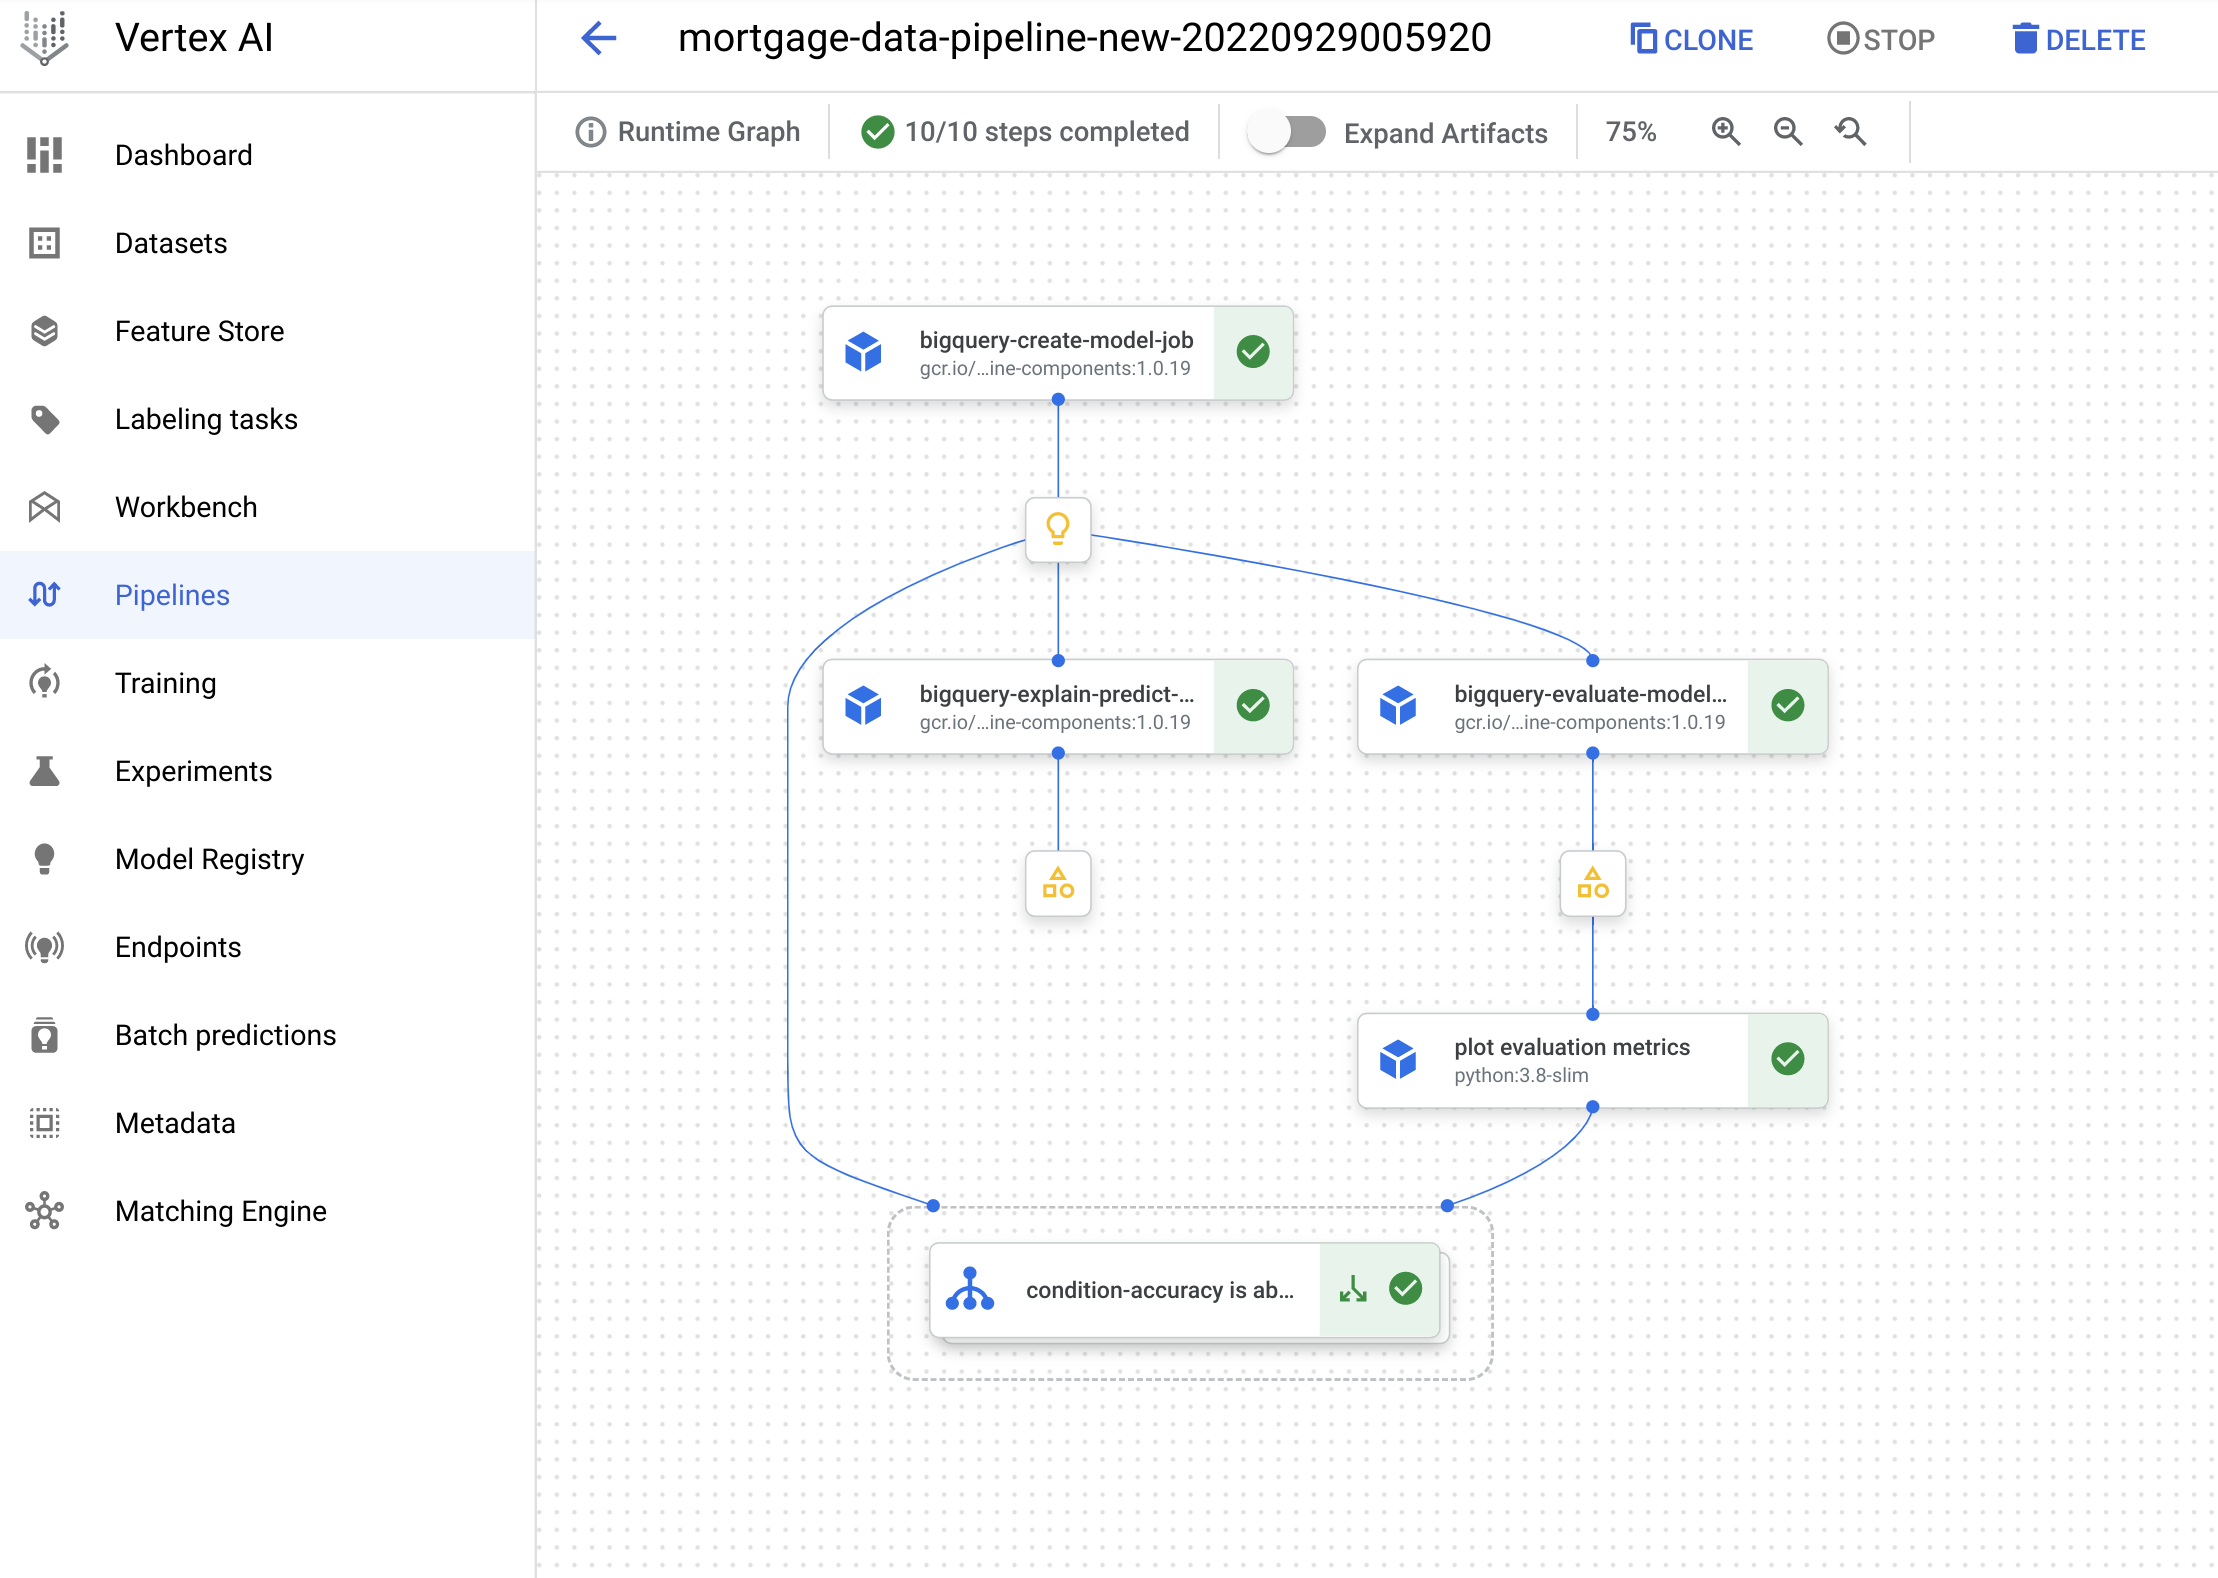




### Go to the BigQuery Console, and Check for the "explain_table_<with Timestamp Table>

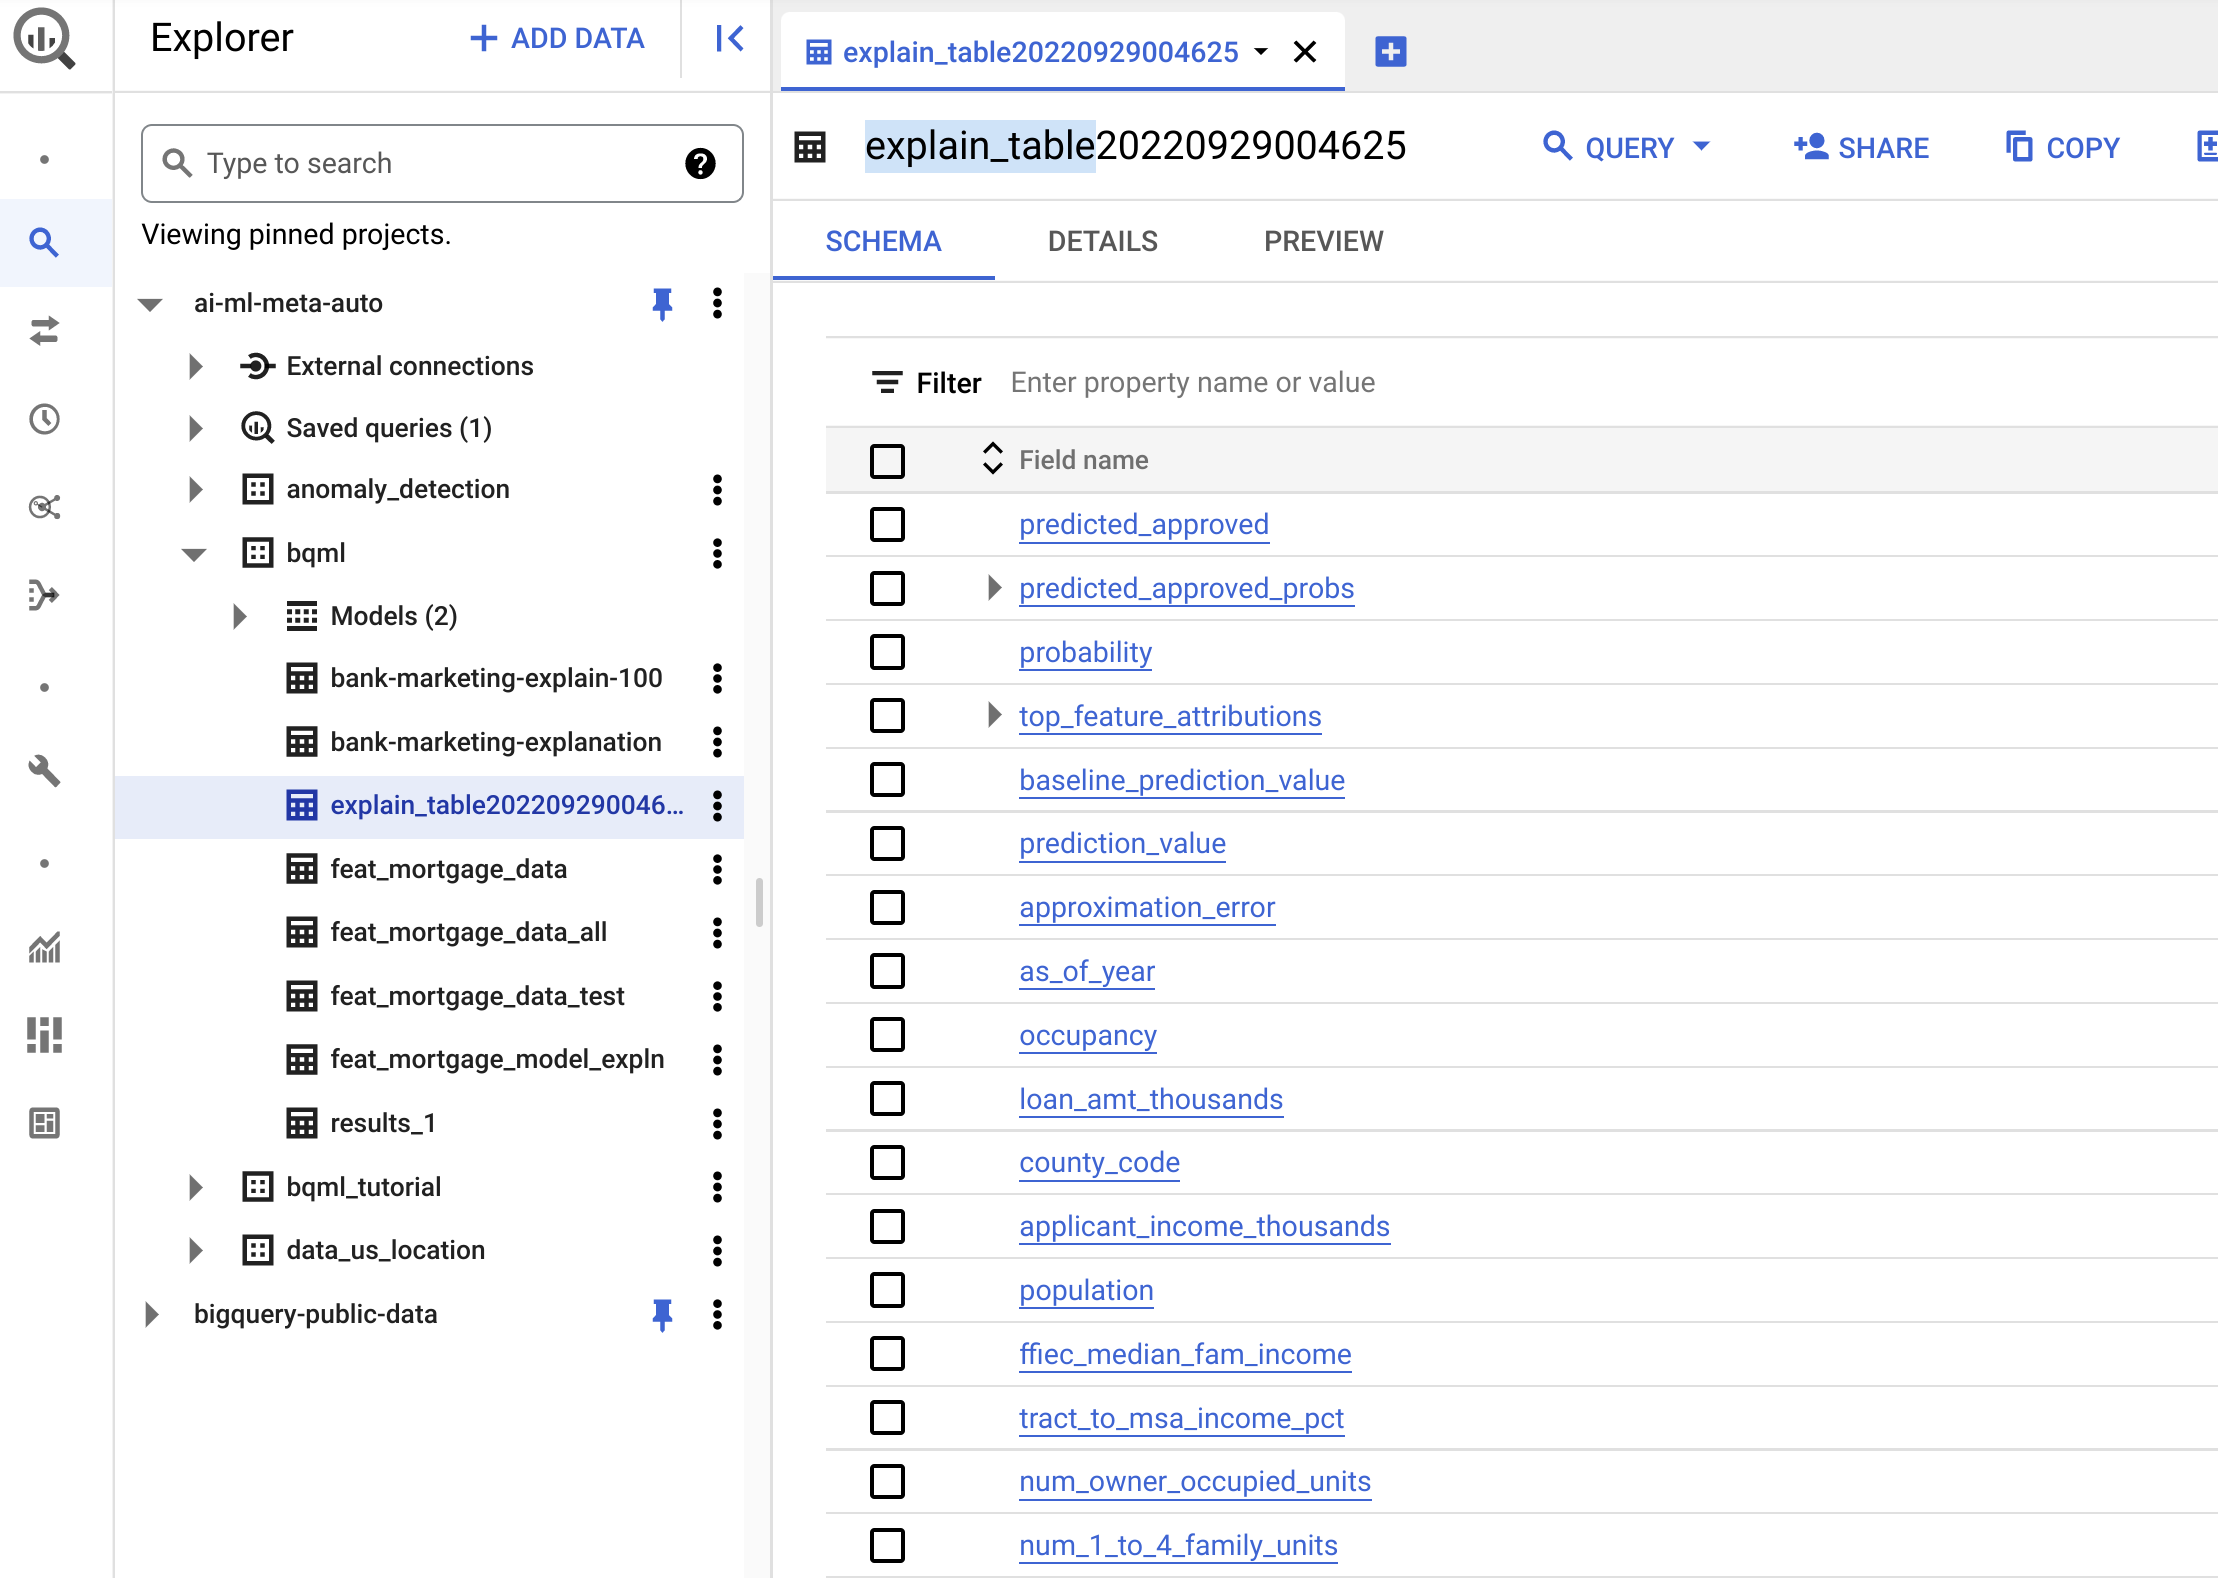

### Click on the Preview of the explain_table to understand the feature attributions
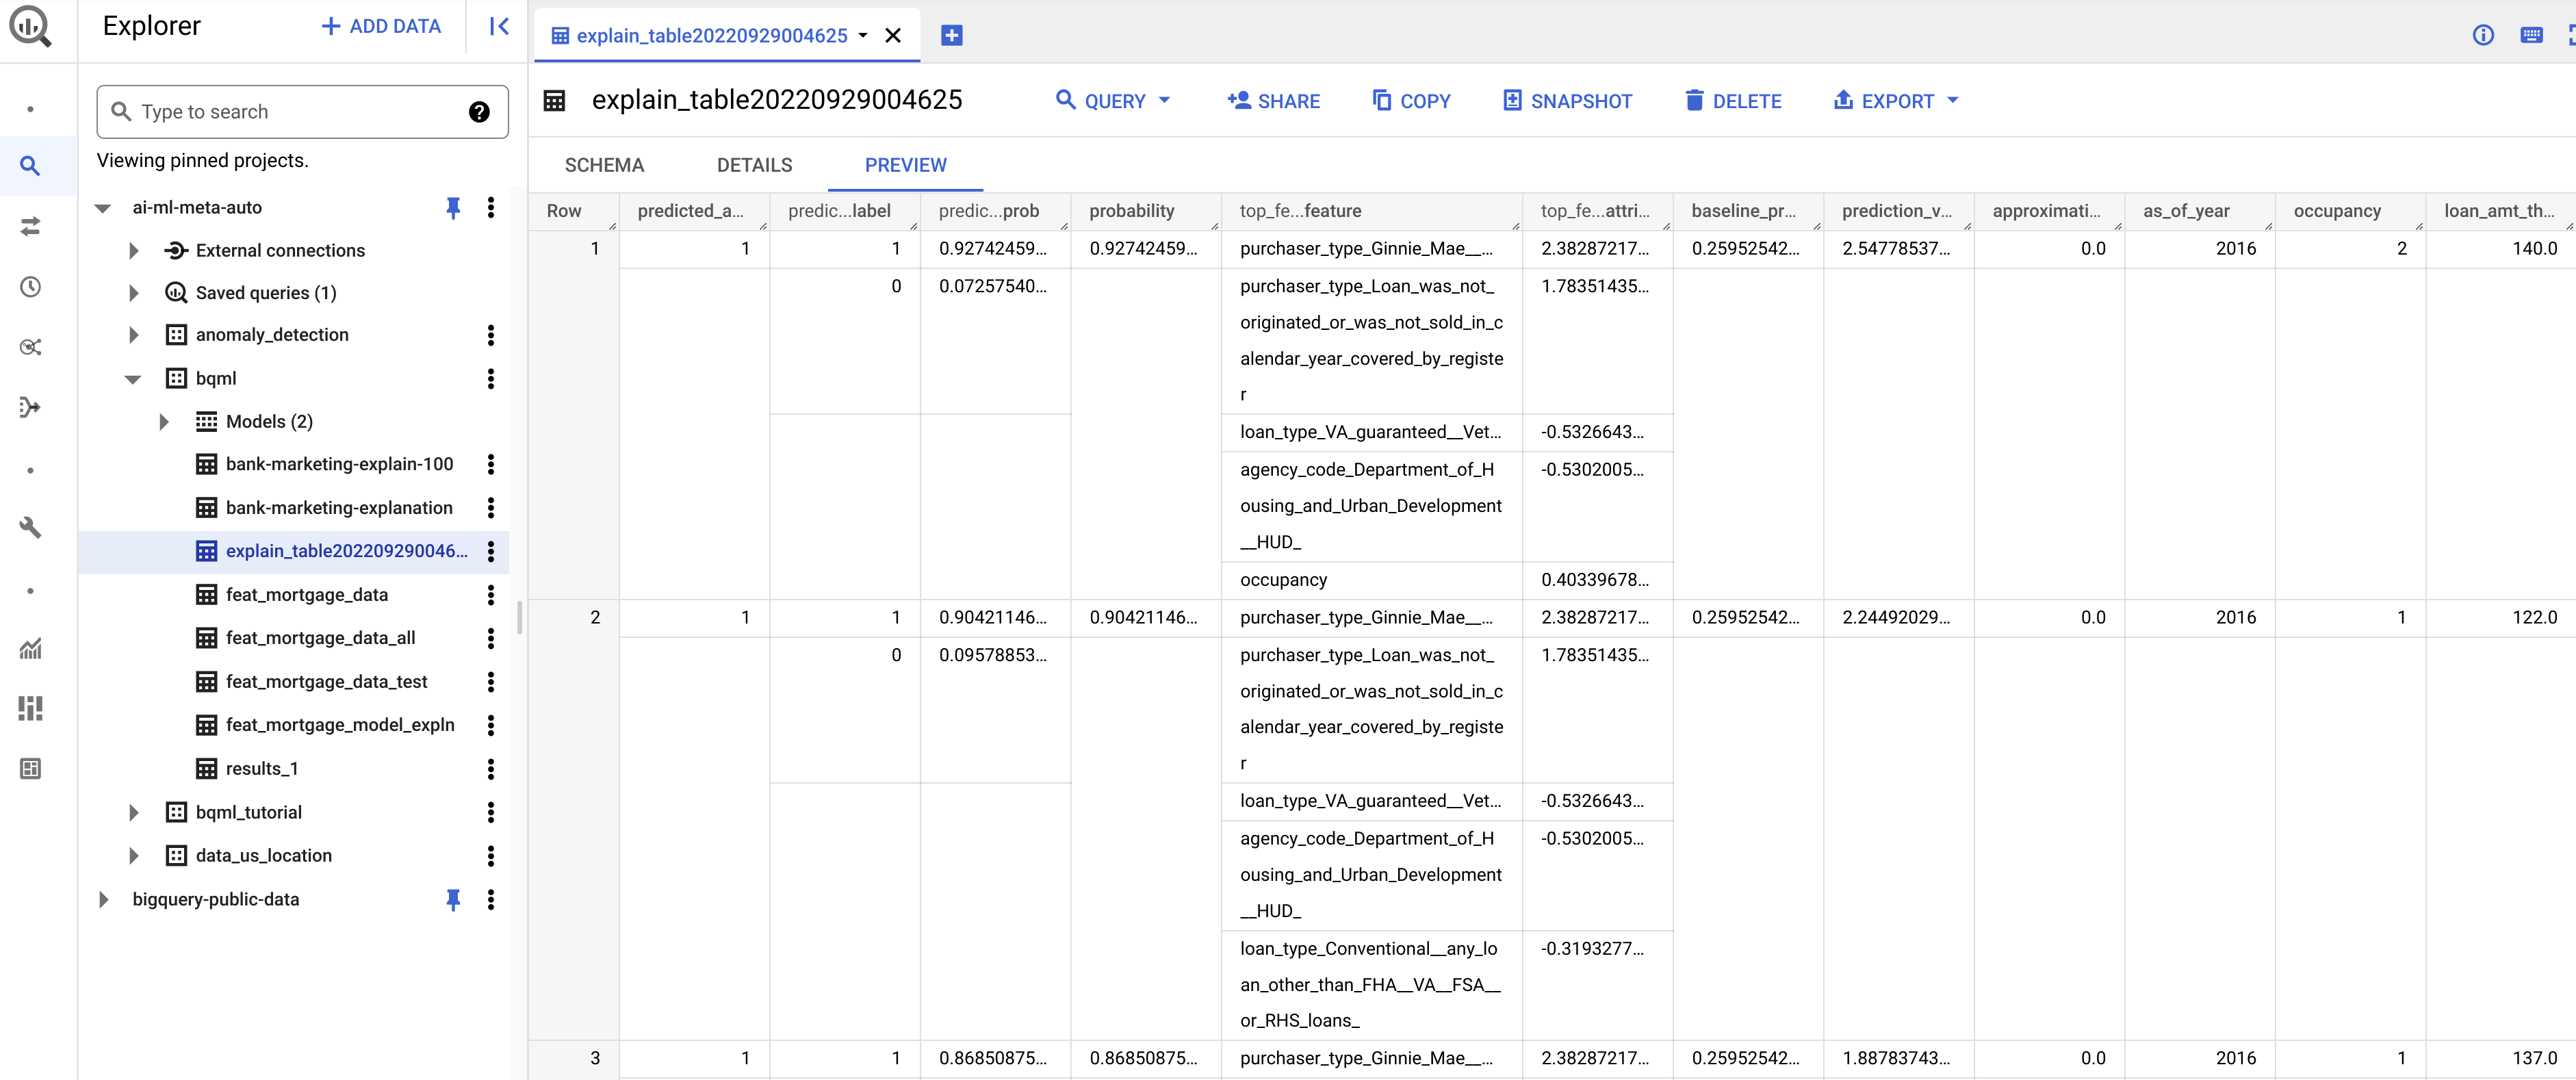